# G@C recycling volume & hk total recycling rate

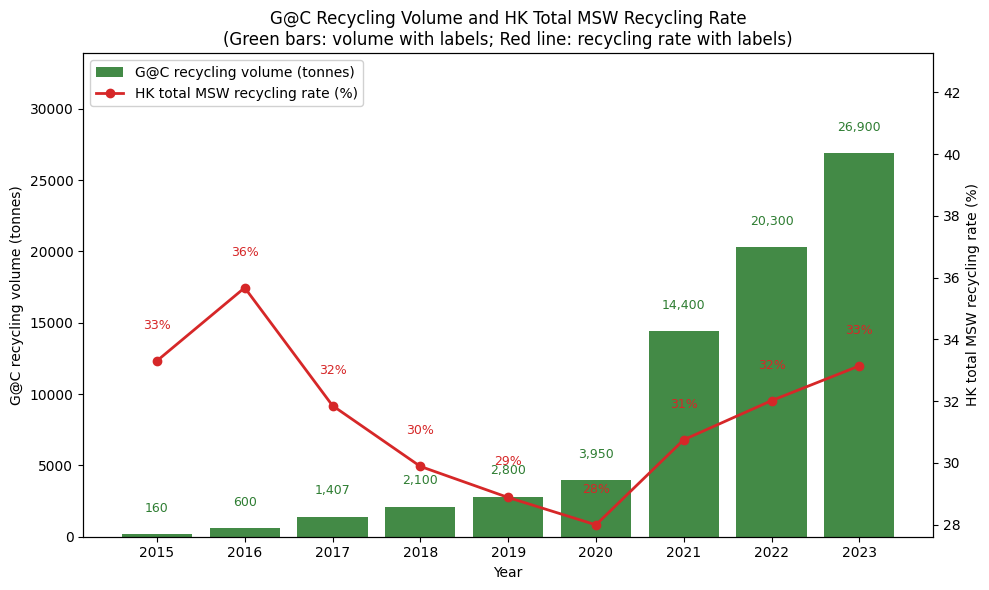

In [3]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("numpy")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

# ---------- load data ----------
# We read the main MSW sheet which already contains both series:
# - "G@C recyclables collection volume (tonnes)"
# - "HK total MSW recycling rate"
data_path = Path("../General Stats_G@C_clean.xlsx")
sheet_msw = "HK MSW Volume and Recycling Rat"
df = pd.read_excel(data_path, sheet_name=sheet_msw, engine="openpyxl")

# ---------- select & clean the needed columns ----------
col_year   = "Year"
col_volume = "G@C recyclables collection volume (tonnes)"
col_rate   = "HK total MSW recycling rate"

# Keep rows where BOTH series have values
mask = df[col_volume].notna() & df[col_rate].notna()
sub  = df.loc[mask, [col_year, col_volume, col_rate]].copy()

# Clean numbers like "41,800.0" -> 41800.0
sub[col_volume] = pd.to_numeric(sub[col_volume].astype(str).str.replace(",", ""), errors="coerce")

# Parse the recycling rate: "40%" -> 40.0 ; if decimals like 0.40, convert to 40.0
rate_num = pd.to_numeric(sub[col_rate].astype(str).str.rstrip("%"), errors="coerce")
sub["rate_pct"] = np.where(rate_num <= 1.0, rate_num * 100.0, rate_num)

# X axis (use the Year column if present; otherwise a simple index)
if col_year in sub.columns and sub[col_year].notna().any():
    # cast to int first so we get "2015" instead of "2015.0"
    x_labels = sub[col_year].astype(float).astype(int).astype(str).tolist()
else:
    x_labels = [str(i+1) for i in range(len(sub))]

x = np.arange(len(sub))

# ---------- plotting ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars: G@C recyclables collection volume (tonnes)
bars = ax1.bar(
    x,
    sub[col_volume],
    color="#2e7d32",
    alpha=0.9,
    label="G@C recycling volume (tonnes)"
)
ax1.set_xlabel("Year")
ax1.set_ylabel("G@C recycling volume (tonnes)", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=0)

# Add headroom for labels above bars
y1min, y1max = ax1.get_ylim()
ax1.set_ylim(y1min, y1max * 1.20)
y1range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
bar_offset = y1range * 0.04

# Label each bar with its value (e.g., "26,900")
for b, v in zip(bars, sub[col_volume]):
    ax1.text(
        b.get_x() + b.get_width()/2,
        b.get_height() + bar_offset,
        f"{v:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#2e7d32",
    )

# Line: HK total MSW recycling rate (%)
ax2 = ax1.twinx()
line, = ax2.plot(
    x,
    sub["rate_pct"],
    color="tab:red",
    marker="o",
    linewidth=2,
    label="HK total MSW recycling rate (%)"
)
ax2.set_ylabel("HK total MSW recycling rate (%)", color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Add headroom for rate labels and place them slightly above the red markers
y2min, y2max = ax2.get_ylim()
ax2.set_ylim(y2min, y2max * 1.20)
y2range = ax2.get_ylim()[1] - ax2.get_ylim()[0]
rate_offset = y2range * 0.06  # extra space so text doesn't sit on the point

for xi, yi in zip(x, sub["rate_pct"]):
    ax2.text(
        xi,
        yi + rate_offset,
        f"{yi:.0f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        color="tab:red",
    )

# Legend
lines = [bars, line]
labels = ["G@C recycling volume (tonnes)", "HK total MSW recycling rate (%)"]
ax1.legend(lines, labels, loc="upper left", frameon=True, framealpha=0.9)

# Title & layout
plt.title(
    "G@C Recycling Volume and HK Total MSW Recycling Rate\n"
    "(Green bars: volume with labels; Red line: recycling rate with labels)"
)
fig.tight_layout()
plt.show()
